# Transfer Learning - bacterial & virus (pediatric)

## denseNet (pytorch)

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from PIL import Image


c:\Users\Churou\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Churou\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10
----------
train Loss: 0.6189 Acc: 0.6855
val Loss: 0.6241 Acc: 0.6737
Epoch 2/10
----------
train Loss: 0.5856 Acc: 0.7235
val Loss: 0.5494 Acc: 0.7368
Epoch 3/10
----------
train Loss: 0.5684 Acc: 0.7417
val Loss: 0.5603 Acc: 0.7322
Epoch 4/10
----------
train Loss: 0.5752 Acc: 0.7235
val Loss: 0.6281 Acc: 0.6561
Epoch 5/10
----------
train Loss: 0.5691 Acc: 0.7279
val Loss: 0.5730 Acc: 0.7696
Epoch 6/10
----------
train Loss: 0.5649 Acc: 0.7393
val Loss: 0.5616 Acc: 0.7415
Epoch 7/10
----------
train Loss: 0.5683 Acc: 0.7308
val Loss: 0.6042 Acc: 0.7415
Epoch 8/10
----------
train Loss: 0.5596 Acc: 0.7437
val Loss: 0.9014 Acc: 0.5135
Epoch 9/10
----------
train Loss: 0.5575 Acc: 0.7370
val Loss: 0.5189 Acc: 0.7637
Epoch 10/10
----------
train Loss: 0.5446 Acc: 0.7516
val Loss: 0.6845 Acc: 0.7099


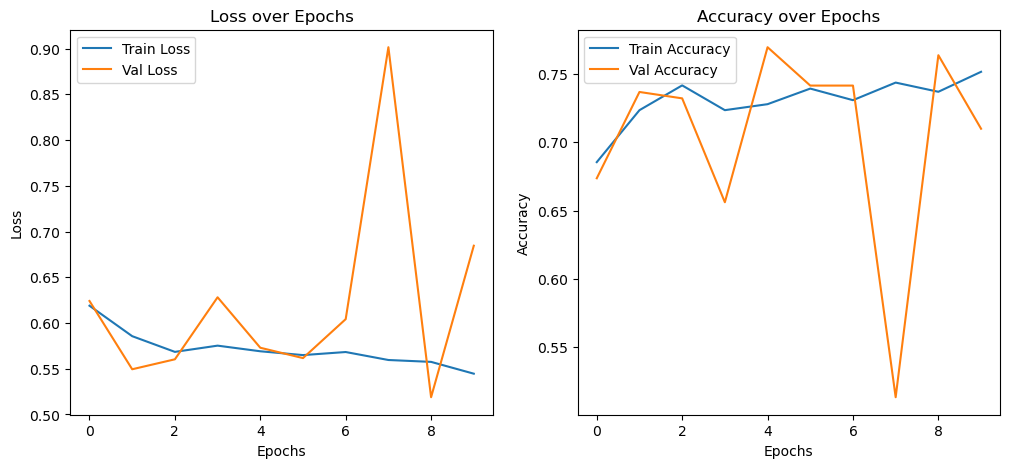

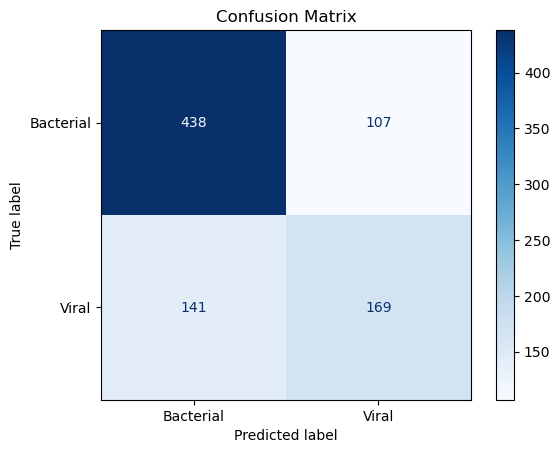

In [2]:
# Data transforms
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    "val": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
}

# Custom Dataset class
class PneumoniaDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.image_paths = [
            os.path.join(folder_path, img)
            for img in os.listdir(folder_path)
            if img.endswith(".jpeg")
        ]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")

        # Label images based on filename
        if "bacteria" in img_path:
            label = 0  # Bacterial pneumonia
        elif "virus" in img_path:
            label = 1  # Viral pneumonia
        else:
            raise ValueError("Unexpected filename format")

        if self.transform:
            image = self.transform(image)

        return image, label

# Define paths and create dataset
data_dir = "./data/Pediatric Chest X-ray Pneumonia/mix"
full_dataset = PneumoniaDataset(data_dir)

# Split dataset into training and validation sets
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Assign appropriate transformations for each dataset
train_dataset.dataset = PneumoniaDataset(data_dir, transform=data_transforms["train"])
val_dataset.dataset = PneumoniaDataset(data_dir, transform=data_transforms["val"])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
dataloaders = {"train": train_loader, "val": val_loader}

# Load pretrained DenseNet
model = models.densenet121(pretrained=True)
num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training history
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

# Training function
def train_model(model, criterion, optimizer, num_epochs=25):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.cpu().item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.cpu().item())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    return model

# Training
model = train_model(model, criterion, optimizer, num_epochs=10)

# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Val Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

plot_training_history(history)

# Confusion matrix
def evaluate_and_plot_confusion_matrix(model):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Bacterial", "Viral"])
    disp.plot(cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()

evaluate_and_plot_confusion_matrix(model)
